#**Anisotropic Total Variation**#
\begin{align*}
\underset{\mathbf{X}}{\text{minimize}} \quad \quad  \frac{1}{2}\| \mathbf{x} - \mathbf{y}\|_F^2 + \tau \sum_{i,j}| \nabla \mathbf{X_{i,j}} |,\\
\text{where } | \nabla \mathbf{X_{i,j}} | = |\mathbf{X}_{i+1,j} - \mathbf{X}_{i,j}| + |\mathbf{X}_{i,j+1} - \mathbf{X}_{i,j}|
\end{align*}

rewrite the problem as 
\begin{align*}
\underset{\mathbf{X}}{\text{minimize}} \quad \quad  \frac{1}{2}\| \mathbf{x} - \mathbf{y}\|_F^2 + \tau \sum_{i=1}^{N-1}\sum_{j=1}^{N}| \mathbf{X_{i+1,j} - \mathbf{X_{i,j}}} | + \tau \sum_{i=1}^{N}\sum_{j=1}^{N-1}| \mathbf{X_{i,j+1} - \mathbf{X_{i,j}}} |,
\end{align*}

By Spliting, we get
\begin{align*}
\underset{\mathbf{X,Z}}{\text{minimize}} \quad \quad  \frac{1}{2}\| \mathbf{x} - \mathbf{y}\|_F^2 + \tau \sum_{i=1}^{N-1}\sum_{j=1}^{N}| \mathbf{X_{i+1,j} - \mathbf{X_{i,j}}} | + \tau \sum_{i=1}^{N}\sum_{j=1}^{N-1}| \mathbf{Z_{i,j+1} - \mathbf{Z_{i,j}}} |,
\text{Subject to } \mathbf{X = Z}
\end{align*}



1. Generate data. Randomly samle M * N normal distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

M = 50
N = 50

img = np.random.normal(0, 1, (M,N))
noisy = img + np.random.normal(0,0.01,(M,N))


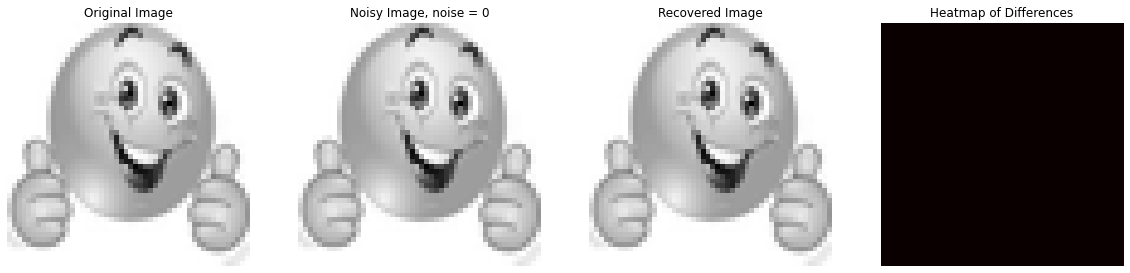

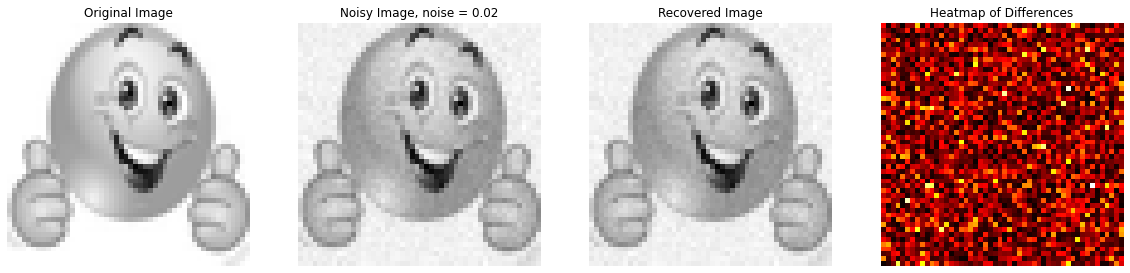

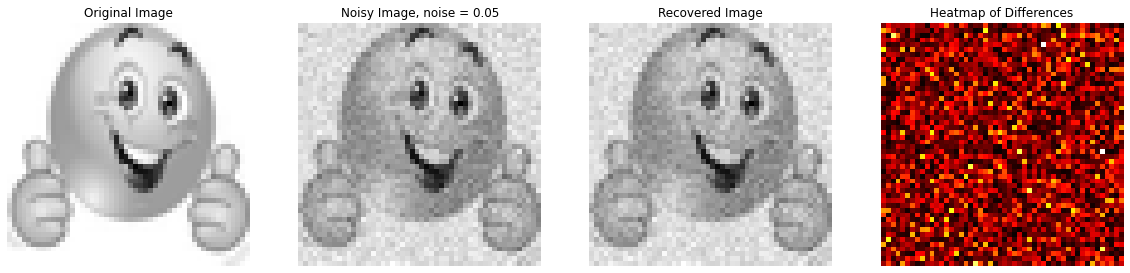

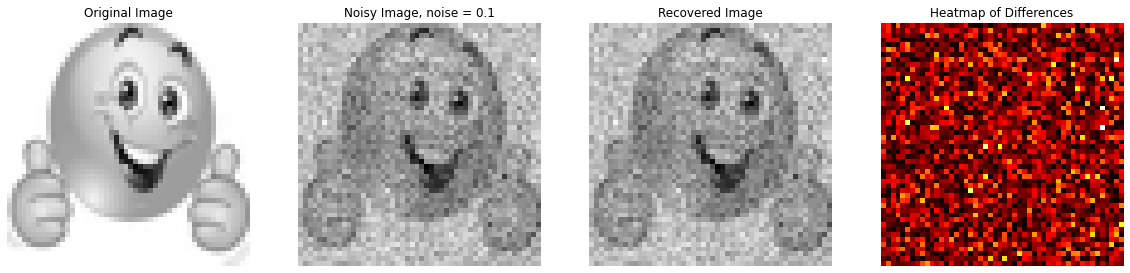

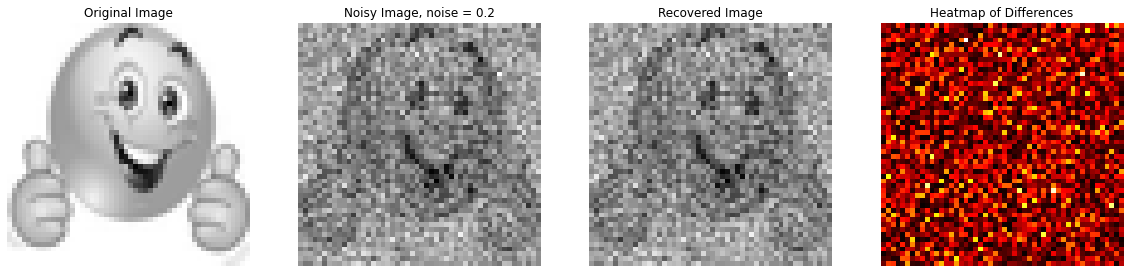

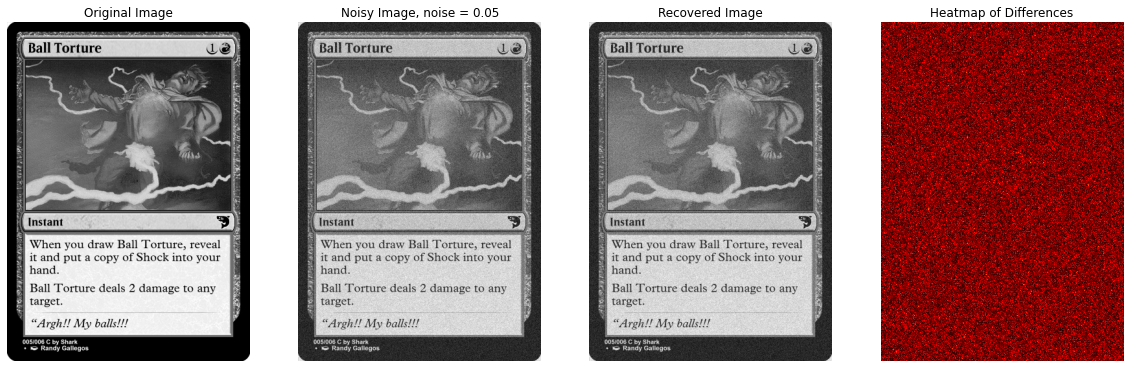

In [77]:
from PIL import Image
from matplotlib import pyplot as plt

def open_as_nparray(filename, desired_width = None, desired_height = None):
  im = Image.open(filename).convert('L')
  #defaults to original size
  if desired_width is not None and desired_height is not None:
    im = im.resize((desired_width, desired_height))
  return np.asarray(im)/255

def add_noise(original_image, noise_amplitude):
  noisy = original_image + np.random.normal(0,noise_amplitude,original_image.shape)
  return noisy

def diff_heatmap(original_image, recovered_image):
  diff = original_image - recovered_image
  return np.absolute(diff)

def comparison_plot(original_image, noisy_image, recovered_image, difference_heatmap, noise):
  fig = plt.figure(figsize = (20, 14))
  rows = 1
  columns = 4
  
  #original image
  fig.add_subplot(rows, columns, 1)
  plt.imshow(original_image, cmap = 'gray')
  plt.axis('off')
  plt.title("Original Image")
  
  #noisy image
  fig.add_subplot(rows, columns, 2)
  plt.imshow(noisy_image, cmap = 'gray')
  plt.axis('off')
  plt.title("Noisy Image, noise = " + str(noise))
  
  #recovered image
  fig.add_subplot(rows, columns, 3)
  plt.imshow(recovered_image, cmap = 'gray')
  plt.axis('off')
  plt.title("Recovered Image")
  
  #difference heatmap
  fig.add_subplot(rows, columns, 4)
  plt.imshow(difference_heatmap, cmap = 'hot')
  plt.axis('off')
  plt.title("Heatmap of Differences")

def plot_from_file(filename, noise, desired_width = None, desired_height = None):
  #defaults to original size
  original = open_as_nparray(filename, desired_width = desired_width, desired_height = desired_height)
  noisy = add_noise(original, noise)
  ###################################
  ######PUT THE FUNCTION HERE########
  recovered = noisy
  ###################################
  
  difference = diff_heatmap(original, recovered)
  comparison_plot(original, noisy, recovered, difference, noise)

def plot_multiple_from_file(filenames, sizes = None, noises = 0.05):
  #sizes can be left blank or set to none to use original sizes
  #to use original size for individual images, set their entry in sizes to None

  #similarly, noises can be a single value, an array of values, or left blank
  if isinstance(noises, (int, float, complex)):
    noise_array = np.full(len(filenames), noises)
  else:
    noise_array = noises

  if sizes is None:
    for (filename, noise) in zip(filenames, noise_array):
      plot_from_file(filename, noise)
  
  else:
    l = len(filenames)
    if l != len(sizes):
      raise Exception("filenames, sizes, and noises must have the same size! sizes and noises can be left blank")

    for (filename, size, noise) in zip(filenames, sizes, noise_array):
      if size is None:
        plot_from_file(filename, noise)
      else:
        plot_from_file(filename, noise, desired_width = size[0], desired_height = size[1])

In [ ]:
filenames = ['smile.jpeg', 'smile.jpeg', 'smile.jpeg', 'smile.jpeg', 'smile.jpeg', 'cbt.png']
#you need to upload your own files because it doesn't save across sessions
sizes = [(50, 50),(50, 50),(50, 50),(50, 50),(50, 50), None]
noises = [0, 0.02, 0.05, 0.1, 0.2, 0.05]
#sizes can be left blank to use original size, or an index can be set to none to use original size
#noises can be left blank to default to 0.05, a single number for the same noise over all images,
#or an arrray of noises if you want different noise on images
plot_multiple_from_file(filenames, sizes = sizes, noises = noises)

2. Create the convolution filter D for 1D total variation denoising.

In [ ]:
def D(x):
    # x is the input vector with length N
    # compute res, an output vector with length N-1
    
    return np.array([x[i] - x[i-1] for i in range(1, x.shape[0])])
  
def DT(y):
    # y is the input vector with length N-1
    # compute res, an output vector with length N
    return np.array([-y[i] if i == 0 else y[i-1] if i== y.shape[0] else y[i-1] - y[i] for i in range(y.shape[0]+1)])
  
def DDT(x):
    # x is the input vector with length N-1
    # compute res, an output vector with length N-1
    
    return np.array([2*x[i] - x[i+1] if i ==0 else 2*x[i] - x[i-1] if i == x.shape[0] -1 else -x[i-1] + 2*x[i] - x[i+1] for i in range(x.shape[0])])

D_matrix = lambda X: np.array([D(x) for x in X])
DT_matrix = lambda Y: np.array([DT(y) for y in Y])
DDT_matrix = lambda X: np.array([DDT(x) for x in X])

 


3. The objective, gradient and proximal operator

\begin{align*}
\text{Lagrangian is given by:} \quad \mathbf{L(X,Z,𝚪)} = \frac{1}{2}\| \mathbf{X} - \mathbf{Y}\|_F^2 + \frac{t}{2}\|\mathbf{X-Z-𝚪}\|_F^2 + \tau \sum_{i=1}^{N-1}\sum_{j=1}^{N}| \mathbf{X_{i+1,j} - \mathbf{X_{i,j}}} | + \tau \sum_{i=1}^{N}\sum_{j=1}^{N-1}| \mathbf{Z_{i,j+1} - \mathbf{Z_{i,j}}} | 
\end{align*}

We then break down the first two terms and complete the squares:

\begin{align*}
\frac{1}{2}\| \mathbf{x} - \mathbf{y}\|_F^2 + \frac{t}{2}\|\mathbf{X-Z-𝚪}\|_F^2 \\
=\frac{1}{2}(\mathbf{X}^2 - 2\mathbf{XY} + \mathbf{Y}^2) + \frac{t}{2}(\mathbf{X}^2 - 2\mathbf{X}(\mathbf{Z} + 𝚪)+(\mathbf{Z}+𝚪)^2)\\
=\frac{1+t}{2}\mathbf{X}^2+\frac{1}{2}(-2\mathbf{X}(\mathbf{Y}-t(\mathbf{Z}+𝚪)))+constant\\
\text{Divide the entire term by } \frac{1+t}{2} \text{ since the minimization problem doesn't change:}\\
\mathbf{X}^2-2\mathbf{X}\frac{\mathbf{Y}-t(\mathbf{Z}+𝚪)}{t+1} + constant\\
\text{Then complete the squares, we get}:
\|\mathbf{X}-\frac{\mathbf{Y}+t(\mathbf{Z}+𝚪)}{t+1}\|_F^2\\
\text{which is equivalent to:} \quad\underset{\mathbf{X}}{\text{minimize}} \quad \quad \frac{1}{2}\|\mathbf{X}-\frac{\mathbf{Y}+t(\mathbf{Z}+𝚪)}{t+1}\|_F^2\\
\text{The new Lagrangian then becomes:}\\\quad \mathbf{L(X,Z,𝚪)} = \frac{1}{2}\|\mathbf{X}-\frac{\mathbf{Y}+t(\mathbf{Z}+𝚪)}{t+1}\|_F^2+ \tau \sum_{i=1}^{N-1}\sum_{j=1}^{N}| \mathbf{X_{i+1,j} - \mathbf{X_{i,j}}} | + \tau \sum_{i=1}^{N}\sum_{j=1}^{N-1}| \mathbf{Z_{i,j+1} - \mathbf{Z_{i,j}}} |
\end{align*}



In [ ]:
f = lambda gamma, y, z, t: 1/2 *pow(np.linalg.norm(y - DT(gamma)), 2) + t/2* pow(np.linalg.norm(to_x(gamma, y) - z + gamma),2)
fp = lambda gamma, y: DDT(gamma) - D(y) 
prox = lambda z, lam: np.maximum(np.minimum(z, lam), -lam)
to_x = lambda gamma, y: y - DT(gamma) 
to_y = lambda y,z,gamma, t: y + t/(t+1)*(z+gamma)

def X_prox_gradient(y, z, gamma, lam, t):
  ss = 1/4
  maxit = 1000
  tol = 1e-15
  change = math.inf
  it = 0
  dual_prob_gamma = np.zeros(y.shape-1)#The small gamma in 1D Total Variation dual problem constraint, not to be confused with ADMM Gamma[i]    #potential bug
  dual_prob_y = to_y(y,z,gamma, t)#The y in dual problem over rows/columns, not to be confused with Y[i]
  while it < maxit and change > tol:
    z = dual_prob_gamma - ss * fp(dual_prob_gamma, dual_prob_y)
    new_gamma = prox(z, lam)
    change = abs(f(new_gamma, y) - f(dual_prob_gamma, y))/ abs(f(dual_prob_gamma, y))
    dual_prob_gamma = new_gamma
    it += 1
  return to_x(dual_prob_gamma, y)

oneDTV = lambda Y, Gamma, lam: np.array([X_prox_gradient(Y[i], Gamma[i], lam) for i in Y.shape[0]]) 



The ADMM function

The X subproblem would then be: \\
\begin{align*}
\quad\underset{\mathbf{X}}{\text{minimize}} \quad \quad \frac{1}{2}\|\mathbf{X}-\frac{\mathbf{Y}+t(\mathbf{Z}+𝚪)}{t+1}\|_F^2 +\tau \sum_{i=1}^{N-1}\sum_{j=1}^{N}| \mathbf{X_{i+1,j} - \mathbf{X_{i,j}}} |\\
\text{The problem could then be decoupled into columns:}\newline
\quad\underset{\mathbf{X}}{\text{minimize}} \quad \quad \sum_{j=1}^{N} \left(\quad \frac{1}{2}\|\mathbf{X_j}-\frac{\mathbf{Y_j}+t(\mathbf{Z_j}+𝚪_\mathbf{j})}{t+1}\|_2^2+\tau \sum_{i=1}^{N-1}| \mathbf{X_{i+1,j} - \mathbf{X_{i,j}}} |\right)\\
\text{Then perform 1D total Variation on each columns, which turns the problem into:}\\
\underset{\mathbf{X}}{\text{minimize}} \quad \sum_{j = 1}^{N} \quad \underset{\boldsymbol{\gamma} \in \mathbb{R}^{N-1}}{\text{minimize}}  \quad \quad & \frac{1}{2}\| \mathbf{y} - \mathbf{D}^T \boldsymbol{\gamma}\|_2^2, \\
\text{subject to}  \quad \quad & \| \boldsymbol{\gamma}\|_\infty \leq \lambda
\end{align*}
where $\nabla \mathbf{x}= \mathbf{D}\mathbf{x}$ , and $y = \frac{\mathbf{Y_j}+t(\mathbf{Z_j}+𝚪_\mathbf{j})}{t+1}$

The Z subproblem would then be:
\begin{align*}
\quad\underset{\mathbf{Z}}{\text{minimize}} \quad \quad \frac{1}{2}\|\mathbf{X}-\frac{\mathbf{Y}+t(\mathbf{Z}+𝚪)}{t+1}\|_F^2 + \tau \sum_{i=1}^{N}\sum_{j=1}^{N-1}| \mathbf{Z_{i,j+1} - \mathbf{Z_{i,j}}} | |\\
\text{Minimizing the term}\quad \mathbf{X}-\frac{\mathbf{Y}+t(\mathbf{Z}+𝚪)}{t+1}\quad \text{is equivalent to minimizing} \quad (t+1)\mathbf{X} - \mathbf{Y}+t(\mathbf{Z} + 𝚪) \quad \text{which is also equivalent to minimizing} \quad \frac{(t+1)\mathbf{X} + \mathbf{Y})}{}  \\
\text{The problem could then be decoupled into columns:}\\
\quad\underset{\mathbf{X}}{\text{minimize}} \quad \quad \sum_{j=1}^{N} \left(\quad \frac{1}{2}\|\mathbf{X_j}-\frac{\mathbf{Y_j}+t(\mathbf{Z_j}+𝚪_\mathbf{j})}{t+1}\|_2^2+\tau \sum_{i=1}^{N-1}| \mathbf{X_{i+1,j} - \mathbf{X_{i,j}}} |\right)\\
\end{align*}

In [ ]:
def ADMM(Y, lam, maxit, tol):
  X = np.zeros(Y.shape)
  Z = np.zeros(Y.shape)
  Gamma = np.zeros(Y.shape)
  it = 0
  X_change = math.inf
  Z_change = math.inf
  t = 2
  while it < maxit and (X_change > tol or Z_change > tol):
    #X subproblem: 1D Total Variation Across the rows
    new_X = oneDTV(Y,Gamma, lam)
    
    Y_T = Y.T 
    Gamma_T = Gamma.T

    #Z subproblem: 1D Total Variation Across the columns
    new_Z = oneDTV(Y.T, Gamma.T, lam).T

    #update Gamma
    Gamma = Gamma + new_X - new_Z

    X_change = np.linalg.norm((new_X - X), ord = 'fro')
    Z_change = np.linalg.norm((new_Z - Z), ord = 'fro')
    X = new_X
    Z = new_Z
  return 